In [1]:
import glob
import h5py
import librosa
import numpy as np
import os
import scipy.signal
import sys
import tqdm

sys.path.append("..")
import localmodule


# t-2 Voice Activity Detection function
def detect_activity(y, sr,
        n_mels=128, fmin=1000, fmax=11025, 
        hop_length=512, gain=0.8, bias=10, power=0.25, pcen_time_constant=0.06, eps=1e-06,
        medfilt_time_constant=None, normalized=True,
        peak_threshold=0.45, activity_threshold=0.2):
    
    # 1. Compute mel-frequency spectrogram
    melspec = librosa.feature.melspectrogram(
        y, sr=sr, fmin=fmin, fmax=fmax, hop_length=hop_length,
        n_mels=n_mels)
    
    # 2. Compute per-channel energy normalization (PCEN-SNR)
    pcen = librosa.core.pcen(melspec, sr=sr, gain=gain, bias=bias,
        power=power, hop_length=hop_length,
        time_constant=pcen_time_constant, eps=eps)
    
    # 3. compute PCEN-SNR detection function
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    if normalized:
        pcen_snr = pcen_snr / np.max(pcen_snr)
        
    # 4. Apply median filtering.
    if medfilt_time_constant is not None:
        medfilt_hops = medfilt_time_constant * sr / hop_length
        kernel_size = max(1, 1 + 2 * round(medfilt_hops - 0.5))
        pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
    
    # 5. Extract active segments.
    activity, start, end = threshold_activity(
        pcen_snr, peak_threshold, activity_threshold)
    
    # 6. Convert indices to seconds.
    start_times = np.round(np.array(start) * hop_length / sr, 3)
    end_times = np.round(np.array(end) * hop_length / sr, 3)
    
    return start_times, end_times, pcen


def threshold_activity(x, Tp, Ta):
    locs = scipy.signal.find_peaks(x,height = Tp)[0]
    y = (x > Ta) * 1
    act = np.diff(y)
    u = np.where(act == 1)[0]
    d = np.where(act == -1)[0]
    signal_length = len(x)
    
    if d[0] < u[0]:
        u = np.insert(u, 0, 0)
        
    if d[-1] < u[-1]:
        d = np.append(d, signal_length-1)
        
    starts = []
    ends = []
    
    activity = np.zeros(signal_length,)
    
    for candidate_up, candidate_down in zip(u, d):
        candidate_segment = range(candidate_up, candidate_down)
        peaks_in_segment = [x in candidate_segment for x in locs]
        is_valid_candidate = np.any(peaks_in_segment)
        if is_valid_candidate:
            starts.append(candidate_up)
            ends.append(candidate_down)
            activity[candidate_segment] = 1.0
            
    starts = np.array(starts)
    ends = np.array(ends)
    
    return activity, starts, ends

In [22]:
data_dir = localmodule.get_data_dir()
participant_paths = glob.glob(os.path.join(
    data_dir, "imitations_participant*.mat"))
n_participants = len(participant_paths)
n_imitations = 100
imitation_matrix = []
species_matrix = []

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    species_list = []
    
    with h5py.File(participant_path, 'r') as h5_file:
        for i in range(n_imitations):
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            imitation_list.append(imitation_waveform)
            species_list.append(species)
        imitation_matrix.append(imitation_list)
        species_matrix.append(species_list)
imitation_matrix = np.array(imitation_matrix)
species_matrix = np.array(species_matrix)

stimuli_waveform = []
with h5py.File(participant_paths[0], 'r') as h5_file:
    for i in range(n_imitations):
        stimulus_waveform = h5_file["#refs#"][h5_file["imitations"]["stimulusAudio"][i][0]][0]
        stimuli_waveform.append(stimulus_waveform)

100%|██████████| 19/19 [00:27<00:00,  1.50s/it]


In [44]:
sr = 44100
stimuli_counts = np.zeros((n_imitations,))
imitation_counts = np.zeros((n_participants, n_imitations))

for stimulus_id, stimulus_waveform in tqdm.tqdm(enumerate(stimuli_waveform)):
    starts, stops, _ = detect_activity(stimulus_waveform, sr)
    stimuli_counts[stimulus_id] = len(starts)
    
    for participant_id in range(n_participants):
        starts, stops, _ = detect_activity(imitation_matrix[participant_id, stimulus_id], sr)
        imitation_counts[participant_id, stimulus_id] = len(starts)

100it [01:16,  1.19it/s]


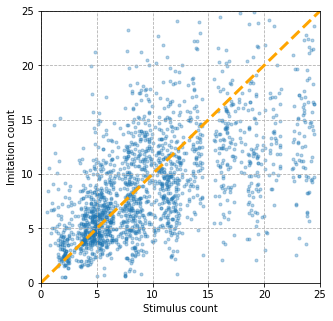

In [99]:
# SCATTER PLOT

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(
    np.ravel(np.tile(stimuli_counts, (n_participants, 1))) + np.random.rand((n_participants*n_imitations)) - 0.5,
    np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - 0.5,
    marker='.', alpha=1/3)
plt.plot([0, 25], [0, 25], '--', color='orange', linewidth=3.0)
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.xlabel("Stimulus count")
plt.ylabel("Imitation count")
plt.grid(linestyle='--')

plt.savefig("vihar2019_segmentation_scatter.png", dpi=1000, bbox_inches="tight")
plt.savefig("vihar2019_segmentation_scatter.eps", bbox_inches="tight")

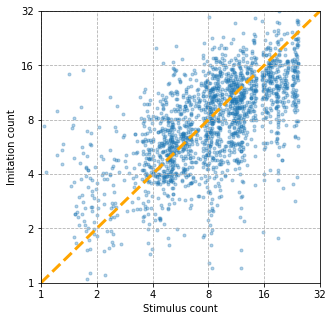

In [98]:
# SCATTER PLOT. (LOG-LOG SCALE)

plt.figure(figsize=(5, 5))
plt.scatter(
    np.log2(np.ravel(np.tile(stimuli_counts, (n_participants, 1))) + np.random.rand((n_participants*n_imitations)) - 0.5),
    np.log2(np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - 0.5),
    marker='.', alpha=1/3)
plt.plot([0, 10], [0, 10], '--', color='orange', linewidth=3.0)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xticks(range(6))
plt.gca().set_xticklabels([2**n for n in range(6)])
plt.xlabel("Stimulus count")
plt.yticks(range(6))
plt.gca().set_yticklabels([2**n for n in range(6)])
plt.ylabel("Imitation count")
plt.grid(linestyle='--')

plt.savefig("vihar2019_segmentation_loglog.png", dpi=1000, bbox_inches="tight")
plt.savefig("vihar2019_segmentation_loglog.eps", bbox_inches="tight")

In [226]:
np.tile(birding_experiences, (n_imitations,1)).T.shape

(19, 100)

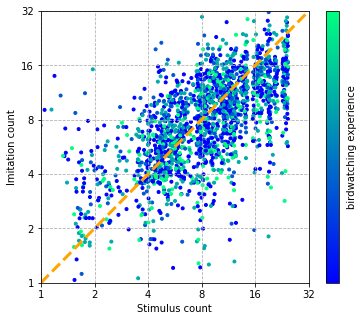

In [265]:
# WITH BIRDWATCHING EXPERIENCE AS COLOR
metadata_path = os.path.join(data_dir, 'BirdVox-imitation_metadata.mat')
with h5py.File(metadata_path) as h5_file:
    birding_experiences = [
        h5_file["#refs#"][h5_file["meta"]["participants"]["birdingExperience"][i][0]][0][0]
        for i in range(n_participants)]
    
plt.figure(figsize=(6, 5))
plt.scatter(
    np.log2(np.ravel(np.tile(stimuli_counts, (n_participants, 1))) + np.random.rand((n_participants*n_imitations)) - 0.5),
    np.log2(np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - 0.5),
    c=np.ravel(np.tile(birding_experiences, (n_imitations,1)).T),
    cmap='winter',
    marker='.')
plt.plot([0, 10], [0, 10], '--', color='orange', linewidth=3.0)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xticks(range(6))
plt.gca().set_xticklabels([2**n for n in range(6)])
plt.xlabel("Stimulus count")
plt.yticks(range(6))
plt.gca().set_yticklabels([2**n for n in range(6)])
plt.ylabel("Imitation count")
plt.grid(linestyle='--')
cbar = plt.colorbar()
cbar.ax.set_yticklabels([])
cbar.ax.tick_params(length=0)
cbar.set_label('birdwatching experience')

plt.savefig("vihar2019_segmentation_loglog_birdwatching.png", dpi=1000, bbox_inches="tight")
plt.savefig("vihar2019_segmentation_loglog_birdwatching.eps", bbox_inches="tight")

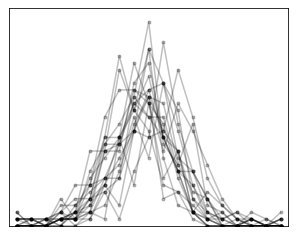

In [250]:
# PER-PARTICIPANT HISTOGRAM
plt.figure(figsize=(5, 4))
count_ratios = (imitation_counts / np.tile(stimuli_counts, (n_participants, 1)))

for participant_id in range(n_participants):
    bin_y, bin_edges = np.histogram(np.log2(count_ratios[participant_id, :]), bins=np.linspace(-3, 3, 20));
    bin_x = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.plot(bin_x, bin_y, '.-', color='k', alpha=0.25)
    
plt.xlim(-3, 3)
plt.ylim(0, 32)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)

plt.savefig("vihar2019_participant_histogram.png", dpi=1000, bbox_inches="tight")
plt.savefig("vihar2019_participant_histogram.eps", bbox_inches="tight")